#### PHY 480 Semester Project
### &#9989; Bergen Kendziorski

#### &#9989; Last Updated on 4/20/24

# Molecular Dynamics of Argon

##  Introduction 

The goal of this project was to create a functional molecular dynamics simulation in order to extract useful properties of argon. The concept of molecular dynamics was started in the 1950's, aimed to simulate systems with large numbers of atoms utilizing the increasing amount of available computational power.$^{[1]}$ These systems could not be solved analytically, as there is no analytical solution due to the large number of particles, each with the possibility of interacting with each other.$^{[2]}$ The basic idea behind molecular dynamics is to simulate the movement of atoms/molecules by solving Newton's equations of motion for the force between them.$^{[2]}$ For the course of this project, I'll be using the Lennard-Jones Potential for the interactions between atoms, as this does a good job of modeling the Van der Walls force.$^{[3]}$ I'll focus on using argon as the interacting particles, as this potential was originally designed for noble gases.$^{[4]}$

The Lennard-Jones potential is defined as: $V(r) = 4\epsilon[(\sigma/r)^{12} - (\sigma/r)^{6}]$ if $r \leq r_c$ where $r_c$ is a cutoff radius, and $V(r) = 0$ if $r \gt r_c$.

source: https://www.thp.uni-koeln.de/trebst/PracticalCourse/molecular_dynamics.html

From this, the force felt by a particle due to another is simply the negative partial derivative of the Lennard-Jones potential with respect to r.

Therefore $F(r) = 4\epsilon[12\sigma^{12}/r^{13} - 6\sigma^{6}/r^{7}]$ if $r \leq r_c$, and F(r) = 0 otherwise.

In order to both test if my code is working as well as to provide a real-world reasoning for doing the simulations in the first place, I aimed to determing the temperatures of phase transitions of argon. These are well established values at a melting point of -189.4 degrees Celsius (83.75 Kelvin) and a boiling point of -185.8 degrees Celsius (87.35 Kelvin).$^{[5]}$ If I could extract this information from my simulations, I would have confirmation that things are working properly. My aim was to rely on the general relationship between potential energy and temperature in materials, where increasing temperature slowly increases the potential energy with sudden jumps in the potential energy at the temperatures corresponding to the phase transitions.

Overall, the questions I set out to investigate were the following:
1. How do the kinetic and potential energies of the system vary as temperature is changed.
2. What are the temperatures of the phase transitions (melting and boiling points) of argon.

## Methodology

The overall method I used to perform the simulations was to initialize a box with periodic boundary conditions, populate the box with argon atoms (needed to determine their initial positions and velocities), and then solve the ODEs associated with the particle interactions using an iterative method.

I used temperature as an input parameter to these simulations, with the idea that if I recorded system potential energy as a function of the temperature, I could simply look for spikes in this function and the corresponding temperatures would be the phase transition temperatures of argon.

The first step in any python project is importing necessary packages, so I'll do that here.

In [25]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import statistics
%matplotlib inline

Next, I needed to initialize some constants and parameters that will be used throughout the simulation.

In [26]:
#system constants/parameters
kb = 1.38065e-23 #boltzmann constant in J/K
tfinal = 100 #final time for iteration
DeltaT = .01 #time step
n = math.ceil(tfinal/DeltaT) #number of steps
mass = 39.948*1.66054e-27  # mass of argon in kilograms
lattice_const = 5.26e-10 #meters

epsilon = 120*kb #Lennard-Jones potential parameter (Joules)
sigma = .3405e-9 #Lennard-Jones potential parameter (meters)
cutoff = 5*sigma # Cutoff distance for Lennard-Jones potential (meters)
box_size = 10*sigma  # Size of the simulation box (meters)
num_particles = 10  # Number of particles

Many of the above are arbitrary choices that I made, such as the final time, time step, and number of particles. My limited computational power was really what set a limit on these, and why I had to use so few particles. With each particle having the potential to interact with all of the other particles at each step, the computational power required increases dramatically with an increasing number of particles in the box.

With this set up, I wrote some of the functions that would be needed in my simulations. The first and most obvious of these is the Lennard-Jones potential and the associated force that I derived above.

In [27]:
def lj_pot(r): #lennard-jones potential
    return 4*epsilon*((sigma/r)**12 - (sigma/r)**6)

def lj_force(r): #just negative derivate of potential wrt r
    return 4*epsilon*(12*(sigma**12)/(r**13) - 6*(sigma**6)/(r**7))

Next, I wrote a function to help with the initialization of the particles' velocities. Since temperature is an input to my simulation, I can determine the average kinetic energy of a particle as $1.5*temperature*k_b$ where $k_b$ is the boltzmann constant, and from there the average speed is $\sqrt{2*KE/mass}$ where $KE$ is the average kinetic energy of a particle. Through this I can know the initial speed of a particle, but to convert to velocity I need to randomize the 3D velocity. Initially, my method had an issue with favoring the vertical axis (See the appendix for more details on this). The math basis for the randomization of theta and phi in the final equation below comes from an article by Karthik Karanth, in the references as source 7.

In [28]:
def velocity_init(mag):
    '''
    Determines particle initial velocities in cartesian coordinates
    Takes in magnitude of velocity, randomizes direction in spherical coordinates,
        and calculates then returns cartesian velocity components
    '''
    u = random.random()
    v = random.random()
    theta = u * 2.0 * math.pi
    phi = math.acos(2.0 * v - 1.0)
    x = mag * np.sin(phi) * np.cos(theta)
    y = mag * np.sin(phi) * np.sin(theta)
    z = mag * np.cos(phi)
    return x,y,z

With a function for determining a random-direction pointing velocity from a given speed, we can now write a function to generate the system of argon atoms as a whole. This is one of the major sections where things had to be dialed back from what I had initially planned. I ended up going with randomized positions inside of the box, and velocities of magnitude equal to the average calculated from the temperature. For more in-depth discussion on what I had initially implemented but had to scrap, see the conclusion.

In [29]:
def system_init(temperature):
    '''
    For a given temperature, initializes a system of argon atoms
    Returns vectors containing positions and velocities for all atoms in cartesian coordinates
    '''
    K = 1.5*temperature*kb #average particle kinetic energy
    v = np.sqrt(2*K/mass) #average particle speed
    positions = np.random.uniform(0, box_size, size=(num_particles, 3))
    velocities = np.empty(shape=(num_particles,3))
    #velocities_lst = []
    for i in range(num_particles):
        x,y,z = velocity_init(v)
        velocities[i][0] = x
        velocities[i][1] = y
        velocities[i][2] = z
        #velocities_lst.append(np.sqrt(x*x+y*y+z*z))
    return positions, velocities

With this all set-up, I was ready to begin the simulation itself. As mentioned before, the simulation was performed for a variety of temperatues, and the final system potential energy was calculated at the end of each simulation.

In [30]:
temperatures = np.linspace(30,120,5) #list of temperatures to perform simulations at
pot_temps = [] #list for storing final potential energy at each temperature
for temperature in temperatures: #loop through temperatures
    t = np.zeros(n)
    
    positions,velocities = system_init(temperature) #initializing system

    # Start integrating
    for curr_step in range(n): #looping through number of steps
        accelerations = np.zeros_like(positions)
        curr_potential = 0

        for i in range(num_particles):
            for j in range(i+1,num_particles):
                r_ij = positions[j] - positions[i]
                r_ij -= np.rint(r_ij/box_size)*box_size
                #r_ij[0] = r_ij[0] % box_size
                #r_ij[1] = r_ij[1] % box_size
                #r_ij[2] = r_ij[2] % box_size
                r_mag = np.linalg.norm(r_ij)

                if(r_mag<cutoff): #force from Lennard-Jones potential nonzero if within cutoff distance
                    force_directed = lj_force(r_mag)*(r_ij/r_mag)
                    accelerations[i] += force_directed/mass
                    accelerations[j] += -1*force_directed/mass
                    curr_potential += 2*np.abs(lj_pot(r_mag))

        #updates after calculating all of the accelerations
        for i in range(num_particles):
            positions[i] = positions[i] + DeltaT*velocities[i] + accelerations[i]*DeltaT*DeltaT/2
            velocities[i] = velocities[i] + .5*DeltaT*accelerations[i]
            t[i+1] = t[i] + DeltaT
            positions[i][0] = positions[i][0] % box_size
            positions[i][1] = positions[i][1] % box_size
            positions[i][2] = positions[i][2] % box_size

            
    pot_temps.append(curr_potential)

## Results and Discussion

The first "result" is really just to make sure that everything is working properly in the simulation. I'll start from the beginning, by showing that the initialization works as intended. To do this, I'll actually initialize a new system, with many many more particles. While actually running the simulation with this many particles would be essentially impossible computationally, I can generate the system to show that the initialization works. The reasoning for this is that I can show that I have an even distribution in positions and velocities.

To begin, let's generate this large system and look at the positions of all the particles.

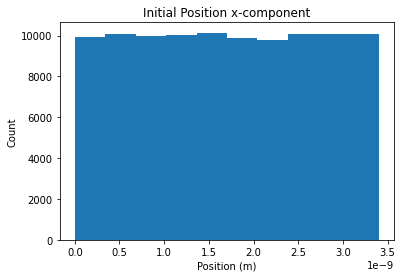

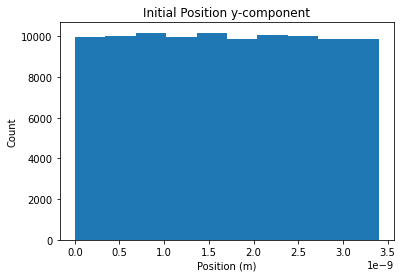

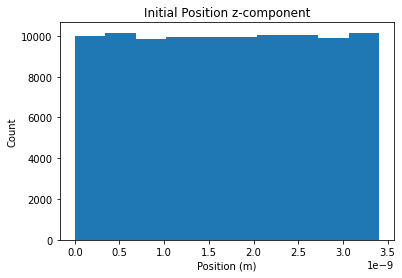

In [31]:
temperature = 50
num_particles = 100000
positions_large, velocities_large = system_init(temperature)

plt.hist(positions_large[:,0])
plt.title("Initial Position x-component")
plt.xlabel("Position (m)")
plt.ylabel("Count")
plt.show()

plt.hist(positions_large[:,1])
plt.title("Initial Position y-component")
plt.xlabel("Position (m)")
plt.ylabel("Count")
plt.show()

plt.hist(positions_large[:,2])
plt.title("Initial Position z-component")
plt.xlabel("Position (m)")
plt.ylabel("Count")
plt.show()

From the above plots, we can see an even distribution across all of the positions in the x, y, and z directions. Additionally, we can see that the particles are all contained within the dimensions of the box, which is $10*\sigma = 3.4*10^{-9}$ meters.

Next, we can look at the particles' velocities.

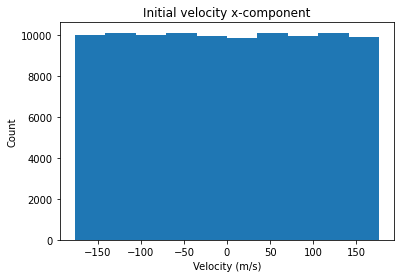

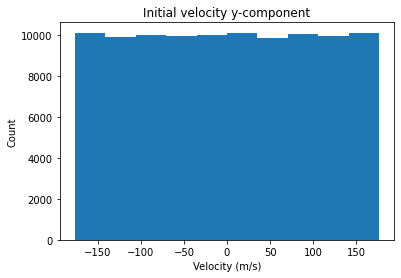

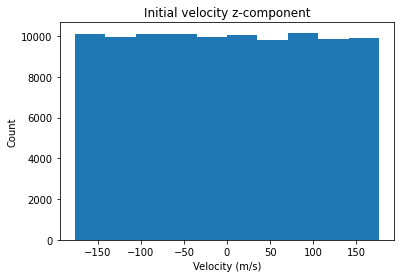

In [32]:
plt.hist(velocities_large[:,0])
plt.title("Initial velocity x-component")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Count")
plt.show()

plt.hist(velocities_large[:,1])
plt.title("Initial velocity y-component")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Count")
plt.show()

plt.hist(velocities_large[:,2])
plt.title("Initial velocity z-component")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Count")
plt.show()

From the above velocity plots, we see an even distribution in all 3 dimensions, so our directions were properly picked uniformly. The appendix shows an example of my earlier code, explains why it had a bias, and shows what these figures would look like if things weren't looking right. Additionally, we can check that the magnitude of the velocities is correct for each particle (showing that our transformation to cartesian components maintained the desired magnitude). This is done below.

In [33]:
velocities_lst = np.sqrt(velocities_large[:,0]*velocities_large[:,0]+velocities_large[:,1]*velocities_large[:,1]+velocities_large[:,2]*velocities_large[:,2])
print("maximum particle speed:", max(velocities_lst))
print("minimum particle speed:", min(velocities_lst))
print("desired particle speed:", np.sqrt(2*1.5*temperature*kb/mass))

maximum particle speed: 176.69132876057395
minimum particle speed: 176.69132876057384
desired particle speed: 176.6913287605739


As we can see, the particles are all at the speed equivalent to the average speed calculated from the temperature of the system.

Now that we've verified the accuracy of our system initialization, let's take a look at the results of our simulations across varying temperatures.

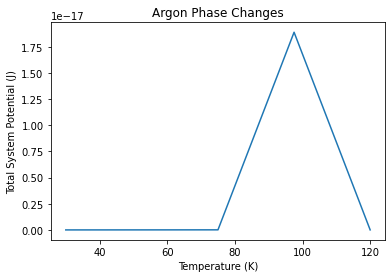

In [34]:
plt.plot(temperatures,pot_temps)
plt.xlabel("Temperature (K)")
plt.ylabel("Total System Potential (J)")
plt.title("Argon Phase Changes")
plt.show()

_(What did you find when you carried out your methods? Some of your code related to presenting results/figures/data may be replicated from the methods section or may only be present in
this section.
All of the plots that you plan on using for your presentation should be present in this section)_

##  Conclusion and Perspectives

Perhaps the biggest issue I ran into was in my initial attempt to code a molecular dynamics simulation in c++. I had some base code from a github repository created by Anders Hafreager, but after way too many hours of still struggling with compiling code I decided to completely start from scratch with python. If I was to do this again I definitely would start with python from the beginning, since the minor benefit of computational efficiency with c++ just isn't worth it in my opinion. Python is also extremely easy with visualizations, which was another think that sucked up a lot of my time trying to figure out while I was still attempting to use c++.

_(What did you learn from your results? What obstacles did you run into? What would you do differently next time? Clearly provide quantitative answers to your question(s)?  At least one of your questions should be answered with numbers.  That is, it is not sufficient to answer "yes" or "no", but rather to say something quantitative such as variable 1 increased roughly 10% for every 1 year increase in variable 2.)_

## References

Karthik Karanth wrote javascript for generation random points on a sphere, which I was able to use as a base for fixing my velocity directions. https://karthikkaranth.me/blog/generating-random-points-in-a-sphere/

_(List the source(s) for any data and/or literature cited in your project.  Ideally, this should be formatted using a formal citation format (MLA or APA or other, your choice!).   
Multiple free online citation generators are available such as <a href="http://www.easybib.com/style">http://www.easybib.com/style</a>. 
**Important:** if you use **any** code that you find on the internet for your project you **must** cite it or you risk losing most/all of the points for you project.)_

##  Appendices
